## Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [95]:
%matplotlib inline
import sys, os, glob, copy

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

In [96]:
# A token is needed to access ADS and it locates at https://ui.adsabs.harvard.edu/user/settings/token

from astroquery import nasa_ads as na

na.ADS.TOKEN = 'Gh2X1K7QxOgpUq0kU3eG3QWNuer5wV6CaIjgkGdp'
na.ADS.NROWS = 20
na.ADS.SORT = 'bibcode desc'
na.ADS.ADS_FIELDS = ['author','title','pubdate', 'bibcode'] # 'bibcode' must be in the field
def get_ref(bibcode): 
    results = na.ADS.query_simple('bibcode:'+bibcode)
    author = results['author'][0][0].split(',')[0]
    year = results['pubdate'][0][0:4]
    return author + year

# try it
get_ref('2013ApJ...767..118C')

'Cool2013'

### Read the HSC-SSP AGN table

https://ui.adsabs.harvard.edu/abs/2020ApJ...894...24K/abstract

In [97]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')
# data_agn

1: spectroscopic redshift from the HSC catalog,

2: spectroscopic redshift from the DEIMOS catalog,

3: photometric redshift from z_best in the Chandra catalog,

4: photometric redshift from ZPDF in the COSMOS2015 catalog.

There are still more with spectra than it appears this table!

Prepare the updated table by copying and adding extra columns 
Only keep DRIMOS (r_z=2) since r_z=1 is DR2 and r_z=3&1 is phot-z

In [98]:
data_agn_updated = copy.deepcopy(data_agn)
data_agn_updated['z4'] = data_agn['z']
data_agn_updated['r_z4'] = data_agn['r_z']
data_agn_updated['z'] = -1.
data_agn_updated['r_z'] = -1

data_agn_updated['z2'] = -1. 
for i in range(len(data_agn)): 
    if data_agn['r_z'][i]==2: 
        data_agn_updated['z2'][i] = data_agn['z'][i]

data_agn_updated

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,z4,r_z4,z2
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,--,--,
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,float64,int64,float64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,-1.0,-1,594392,1.561,3,-1.0
2,150.73557,2.19957,20.36,1,1,1,1,1,6,-1.0,-1,592797,3.499,1,-1.0
3,150.73353,2.15646,20.88,1,1,1,1,1,6,-1.0,-1,565402,0.977,1,-1.0
4,150.79702,2.13888,21.01,1,1,1,1,1,6,-1.0,-1,552225,0.573,1,-1.0
5,150.78259,2.19306,20.63,1,1,1,1,1,6,-1.0,-1,589540,0.585,1,-1.0
6,150.72019,2.24803,21.13,1,1,1,1,1,6,-1.0,-1,625595,0.664,1,-1.0
7,150.78838,2.34399,19.82,1,1,1,1,1,6,-1.0,-1,689768,1.964,1,-1.0
8,150.71511,2.48483,19.2,1,1,1,1,1,6,-1.0,-1,782508,1.999,1,-1.0


### Match to SIMBAD using `astroquery`

Description for `add_votable_fields` refers to:  
https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

In [99]:
from astroquery.simbad import Simbad

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode', 'flux(i)')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' and rvz_qual!='E' should have an optical spectrum
print(len(result_table[result_table['RVZ_WAVELENGTH']=='O'])) 
#TODO: Possibly add N (near-ir)

mask_spec_simbad = (result_table['RVZ_WAVELENGTH']=='O') & (result_table['RVZ_QUAL']!='E') 

result_table.write('result_table.txt', format='csv', overwrite=True)

313


/Users/colinburke/miniconda3/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 89 raised an error (recorded in the `errors` attribute of the result table): '10:01:58.956 +2:24:45.216': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "


add result into updated table (bibcode incomplete)

In [21]:
simbad_bibcodes, _ = np.unique(result_table[mask_spec_simbad]['RVZ_BIBCODE'], return_counts=True)

data_agn_updated['z0'] = -1.
data_agn_updated['r_z0'] = -1

idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[mask_spec_simbad]

simbad_rz_codes = {}
for i, bibcode in enumerate(simbad_bibcodes): 
    simbad_rz_codes.update({bibcode: i+1})

for j,i in enumerate(idx_simbad_specz):
    data_agn_updated['z0'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_updated['r_z0'][i] = simbad_rz_codes[result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]]

### Match to HSC PDR3 

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

query website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/catalog-of-spectroscopic-redshifts__pdr3/

#### Obtain the HSC data and see what database it comes from

We first download all the spectra in cosmos field and then filter them using python. HSC catalog uses `SQL` to inquire about the redshift, which is not suitable for mass and fuzzy inquiry. 

```sql

SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift
      , specz_duplicationflag

      , specz_flag_zcosmos_bright_dr3
      , specz_flag_3dhst_v4_1_5
      , specz_flag_sdss_dr15
      , specz_flag_gama_dr3
      , specz_flag_udsz_dr1
      , specz_flag_vandels_dr2
      , specz_flag_c3r2_dr2
      , specz_flag_vvds_drfinal
      , specz_flag_deimos_2018
      , specz_flag_fmos_dr2
      , specz_flag_lega_c_dr2
      , specz_flag_primus_dr1
      , specz_flag_vipers_dr2
      , specz_flag_wigglez_dr1
      , specz_flag_deep23_dr4_egs

    FROM pdr3_dud_rev.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;

```

It will return a `csv` file that contains all the spec-z in COSMOS field. I have renamed it to `hsc-spec-cosmos.txt`

In [104]:
data_coords = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit=u.deg)
print(len(data_coords))

source_keys = ['specz_flag_zcosmos_bright_dr3', 'specz_flag_3dhst_v4_1_5', 'specz_flag_sdss_dr15', 'specz_flag_gama_dr3', 'specz_flag_udsz_dr1', 'specz_flag_vandels_dr2', 'specz_flag_c3r2_dr2', 'specz_flag_vvds_drfinal', 'specz_flag_deimos_2018', 'specz_flag_fmos_dr2', 'specz_flag_lega_c_dr2', 'specz_flag_primus_dr1', 'specz_flag_vipers_dr2', 'specz_flag_wigglez_dr1', 'specz_flag_deep23_dr4_egs']
hsc_targets = ascii.read('hsc-spec-cosmos.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])
hsc_duplication_mask = hsc_targets['specz_duplicationflag']==10

idx_hsc_pdr3, idx_hsc_specz, d2d, d3d = data_coords.search_around_sky(hsc_coords, 0.5*u.arcsec)
# Index to mask


print(len(hsc_targets[idx_hsc_pdr3]))
# plt.hist(d2d.to(u.arcsec).value, bins=100);

491
379


In [107]:
np.count_nonzero(hsc_targets[idx_hsc_pdr3]['specz_flag_3dhst_v4_1_5'])

14

Fill in the updated table

In [105]:
data_agn_updated['z1'] = -1.
data_agn_updated['r_z1'] = -1

#    flag_name                         bibcode                description       rz_code        
hsc_bibcodes = {
    'specz_flag_zcosmos_bright_dr3': ['2009ApJS..184..218L', 'zCOSMOS DR3    ', 1],
    'specz_flag_3dhst_v4_1_5':       ['2016ApJS..225...27M', '3D-HST v4.1.5  ', 2],
    'specz_flag_sdss_dr15':          ['2020ApJS..249....3A', 'SDSS DR15      ', 3],
    'specz_flag_c3r2_dr2':           ['2017ApJ...841..111M', 'C3R2 DR2       ', 4],
    'specz_flag_vvds_drfinal':       ['2013A&A...559A..14L', 'VVDS DRFinal   ', 5],
    'specz_flag_deimos_2018':        ['2018ApJ...858...77H', 'DEIMOS         ', 6],
    'specz_flag_fmos_dr2':           ['2015ApJS..220...12S', 'FMOS COSMOS DR2', 7],
    'specz_flag_lega_c_dr2':         ['2018ApJS..239...27S', 'LEGA-C DR2     ', 8],
    'specz_flag_primus_dr1':         ['2013ApJ...767..118C', 'PRIMUS         ', 9],
}

for j,i in enumerate(idx_hsc_specz):
    data_agn_updated['z1'][i] = hsc_targets['specz_redshift'][idx_hsc_pdr3[j]]
    source_key = [key for key in source_keys if hsc_targets[i][key]==True][0]
    data_agn_updated['r_z1'][i] = hsc_bibcodes[source_key][2]

### Match to COSMOS2020 to get photometry and photo-z

#### COSMOS2020

https://cosmos2020.calet.org/catalogues/

Format : https://cosmos2020.calet.org/catalogues/COSMOS2020_DR4_1_1.pdf

In [24]:
dir_in = './'  
catversion = 'Farmer' 
data_cosmos2020 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

Actually do the matching to COSMOS2020

In [25]:
cat_COSMOS2020 = SkyCoord(data_cosmos2020['ALPHA_J2000'], data_cosmos2020['DELTA_J2000'], unit='deg')

idx_agn2COSMOS20, idx_COSMOS20, d2d, d3d = cat_COSMOS2020.search_around_sky(cat_agn, 0.6*u.arcsec)
# MISSING A FEW SOURCES COSMOS2015->COSMOS2020
print(len(idx_COSMOS20), print(len(cat_agn)))

491
455 None


fill in the table

In [26]:
data_agn_updated['z3'] = -1. 

data_agn_updated['z3'][idx_agn2COSMOS20] = data_cosmos2020['lp_zq'][idx_COSMOS20]
data_agn_updated['z3'][~np.isfinite(data_agn_updated['z3'])] = -1.

Some of these spec-z's are wrong so careful there

### Compile the data above

fill out the best z column by overwriting with 

SIMBAD > HSC > COSMOS2020, NO DEIMOS or original

z0 > z1 > z3

In [27]:
for i in [3, 1, 0]: 
    mask_z = data_agn_updated['z%d'%i]!=-1
    data_agn_updated['z'][mask_z] = data_agn_updated['z%d'%i][mask_z]
    data_agn_updated['r_z'][mask_z] = i

fill in the header

In [28]:
#    r_z      bibcode                description           comment refcode
profile = table.Table(data=np.array([
        ['0', sum(data_agn_updated['r_z']==0), 'see below', 'SIMBAD', '', '-'],
        ['1', sum(data_agn_updated['r_z']==1), 'see below', 'HSC DR3', '', '-'],
        ['3', sum(data_agn_updated['r_z']==3), '2016ApJ...819...62C', 'COSMOS2020', '', get_ref('2016ApJ...819...62C')],
        ['4', 0, 'see below', 'Kiruma2020', '', '-'],
    ]), 
    names=['r_z', 'count', 'bibcode', 'description', 'comment', 'refcode'], 
    dtype=('U5', 'i4', 'U19', 'U21', 'U21', 'U21')
)
for col in profile.columns: 
    profile[col].format='<'

# add z0 (SIMBAD)
for i, bibcode in enumerate(simbad_bibcodes): 
    count = np.unique
    profile.add_row(['z0_%02d'%(i+1), sum(data_agn_updated['r_z0']==i+1), bibcode, '', '', get_ref(bibcode)])

profile[np.where(profile['bibcode']=='2009ApJ...696.1195T')[0][0]]['description'] = 'Magellan'
profile[np.where(profile['bibcode']=='2018ApJ...858...77H')[0][0]]['description'] = 'DEIMOS'

# add z1 (HSC DR3)
for i, bibcode in enumerate(hsc_bibcodes.values()): 
    profile.add_row(['z1_%02d'%(i+1), sum(data_agn_updated['r_z1']==i+1), bibcode[0], bibcode[1].strip(), '', get_ref(bibcode[0])])
profile[np.where(profile['bibcode']=='2009ApJS..184..218L')[0][0]]['comment'] = 'may overestimate z'
profile[np.where(profile['bibcode']=='2013ApJ...767..118C')[0][0]]['comment'] = 'may underestimate z'

profile.write('source_profile.txt', format='latex', overwrite=True)
profile.pprint_all()

 r_z  count       bibcode         description         comment           refcode    
----- ----- ------------------- --------------- ------------------- ---------------
0     305   see below           SIMBAD                              -              
1     102   see below           HSC DR3                             -              
3     71    2016ApJ...819...62C COSMOS2020                          Civano2016     
4     0     see below           Kiruma2020                          -              
z0_01 31    2007ApJS..172...70L                                     Lilly2007      
z0_02 1     2009ApJ...693....8B                                     Brusa2009      
z0_03 177   2009ApJ...696.1195T Magellan                            Trump2009      
z0_04 1     2012ApJ...753..121K                                     Knobel2012     
z0_05 1     2012ApJ...758...47A                                     Allevato2012   
z0_06 1     2012ApJS..203...21A                                     Ahn2012 

save the table

In [29]:
table_header = profile.pformat_all(align='<')
data_agn_updated.meta['comments'] = table_header

data_agn_updated = data_agn_updated['ID', 'RAdeg', 'DEdeg', 'i-mag', 'X-flag', 'g-flag', 'r-flag', 'i-flag', 'z-flag', 'n-corr', 'ID-COSMOS2015', 'z', 'z0', 'z1', 'z2', 'z3', 'z4', 'r_z', 'r_z0', 'r_z1', 'r_z4']
ascii.write(data_agn_updated, 'hsc_agn_updated.txt', format='rst', overwrite=True)
data_agn_updated

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,ID-COSMOS2015,z,z0,z1,z2,z3,z4,r_z,r_z0,r_z1,r_z4
--,deg,deg,mag,--,--,--,--,--,--,--,--,,,,,--,--,,,--
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,594392,1.58,-1.0,-1.0,-1.0,1.58,1.561,3,-1,-1,3
2,150.73557,2.19957,20.36,1,1,1,1,1,6,592797,3.5026,3.5026,3.503096,-1.0,-1.0,3.499,0,7,2,1
3,150.73353,2.15646,20.88,1,1,1,1,1,6,565402,0.979,0.979,0.9769,-1.0,1.03,0.977,0,3,2,1
4,150.79702,2.13888,21.01,1,1,1,1,1,6,552225,0.5727,0.5727,0.5727,-1.0,0.51,0.573,0,14,2,1
5,150.78259,2.19306,20.63,1,1,1,1,1,6,589540,0.5824,0.5824,0.5847,-1.0,-1.0,0.585,0,3,2,1
6,150.72019,2.24803,21.13,1,1,1,1,1,6,625595,0.6652,0.6652,0.6633,-1.0,0.62,0.664,0,3,2,1
7,150.78838,2.34399,19.82,1,1,1,1,1,6,689768,1.9555,1.9555,1.964449,-1.0,2.0,1.964,0,3,2,1
8,150.71511,2.48483,19.2,1,1,1,1,1,6,782508,2.0051,2.0051,1.995,-1.0,-1.0,1.999,0,3,2,1


#### Visually check our data completeness

This plot is for fun. It will not be used in the paper since it is too complicated. 

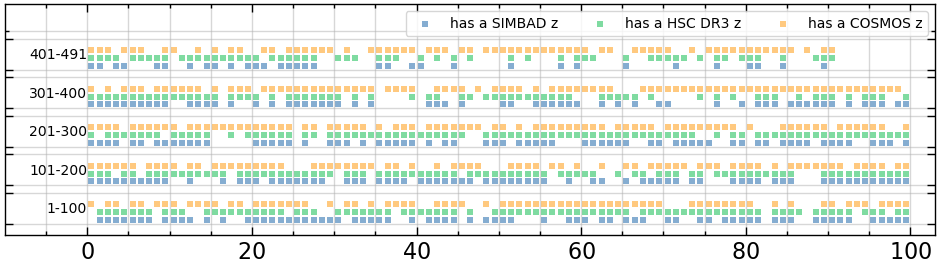

In [30]:
plt.figure(figsize=[12, 3])

ID = data_agn_updated['ID']
mask_simbad = data_agn_updated['z0']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_simbad], ((ID-1)//100+0.1)[mask_simbad], linewidths=0, alpha=0.5, s=20, marker='s', label='has a SIMBAD z')
mask_hsc = data_agn_updated['z1']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_hsc], ((ID-1)//100+0.1+0.2)[mask_hsc], linewidths=0, alpha=0.5, s=20, marker='s', label='has a HSC DR3 z')
# mask_deimos = data_agn_updated['z2']!=-1.
# plt.scatter(((ID-1)%100+0.5)[mask_deimos], ((ID-1)//100+0.1+0.4)[mask_deimos], linewidths=0, alpha=0.5, s=20, marker='s', label='has a DEIMOS z')
mask_cosmos = data_agn_updated['z3']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_cosmos], ((ID-1)//100+0.1+0.4)[mask_cosmos], linewidths=0, alpha=0.5, s=20, marker='s', label='has a COSMOS z')

plt.legend(frameon=True, ncol=4, fontsize=10)
plt.text(-0, 0.4, '1-100', size=10, ha='right', va='center')
plt.text(-0, 1.4, '101-200', size=10, ha='right', va='center')
plt.text(-0, 2.4, '201-300', size=10, ha='right', va='center')
plt.text(-0, 3.4, '301-400', size=10, ha='right', va='center')
plt.text(-0, 4.4, '401-491', size=10, ha='right', va='center')
plt.xlim(-10, 103)
plt.ylim(-0.3, 5.7)

plt.yticks([0, 0.8, 1, 1.8, 2, 2.8, 3, 3.8, 4, 4.8], '')
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.5)

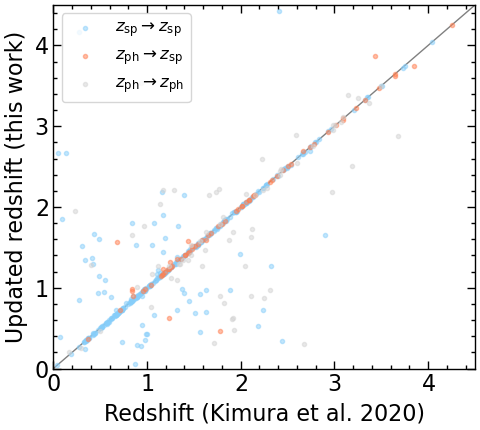

In [31]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

# mask_unchanged = (data_agn_updated['r_z']==4)
# ax.scatter(data_agn_updated['z4'][mask_unchanged], data_agn_updated['z'][mask_unchanged], 
#            marker='.', color='gray', label=r'unchanged', alpha=0.5)

mask_sp2sp = (data_agn_updated['r_z4']<=2) & (data_agn_updated['r_z']<=2)
ax.scatter(data_agn_updated['z4'][mask_sp2sp], data_agn_updated['z'][mask_sp2sp], 
           marker='.', color='lightskyblue', label=r'$z_{\rm sp} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2sp = (data_agn_updated['r_z4']>=3) & (data_agn_updated['r_z']<=2)
ax.scatter(data_agn_updated['z4'][mask_ph2sp], data_agn_updated['z'][mask_ph2sp], 
           marker='.', color='coral', label=r'$z_{\rm ph} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2ph = (data_agn_updated['r_z4']>=3) & (data_agn_updated['r_z']>=3)
ax.scatter(data_agn_updated['z4'][mask_ph2ph], data_agn_updated['z'][mask_ph2ph], 
           marker='.', color='lightgray', label=r'$z_{\rm ph} \rightarrow z_{\rm ph}$', alpha=0.5)

ax.plot([0, 4.5], [0, 4.5], lw=1, zorder=-2, color='gray')
ax.set_xlabel('Redshift (Kimura et al. 2020)')
ax.set_ylabel('Updated redshift (this work)')
ax.legend(frameon=True, loc=2, fontsize=12)
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)
fig.savefig('specz.pdf', dpi=300)

fig.tight_layout()

manually check inconsistent zs

In [32]:
z_list = ['z0', 'z1', 'z2']
inconsistent_z = table.Table(names=(['ID']+z_list), dtype=([np.int64]+[np.float64]*len(z_list)))
for i in range(len(data_agn_updated)): 
    z = data_agn_updated[i][z_list]
    z_filtered = [j for j in z if j!=-1.]
    if z_filtered!=[]: 
        if np.max(z_filtered)-np.min(z_filtered)>0.1: 
            inconsistent_z.add_row(data_agn_updated[i][['ID'] + z_list])
            # print(data_agn_download[ID][['ID'] + z_list])
inconsistent_z.pprint_all()

 ID    z0        z1       z2 
--- ------- ----------- -----
 11   0.925      1.5652  -1.0
 17  1.2651      2.3219  -1.0
 27  0.9736       1.634 1.634
 40  1.1433      0.4924  -1.0
 76  0.8913   1.5563668  -1.0
 90  1.2995  0.42066365  -1.0
103   1.606   0.4906261  -1.0
127   1.797   1.0733103  -1.0
137  2.1458     1.40008  -1.0
139  1.5145      1.9289  -1.0
145  0.9793      1.7592  -1.0
153   0.695    1.001973  -1.0
193   2.673 0.045087364  -1.0
197    0.34      1.9582  -1.0
201  1.8456 0.090319805  -1.0
206  0.4967      0.6911  -1.0
221  0.3236      0.7344  -1.0
223 0.74829      0.5773  -1.0
227  0.4586      1.5659  -1.0
237  2.6681  0.13425398  -1.0
256  1.4797   0.3996155  -1.0
257  0.4319   1.0107826  -1.0
270  1.7977   0.8445786  -1.0
273  0.4311       1.596  -1.0
292  0.5368   0.9435049  -1.0
300    4.17   0.2762015  -1.0
331  0.7284      2.2335  -1.0
367  0.7252      1.3247  -1.0
384  0.9388      1.3955 1.395
400   0.942   1.0770499  -1.0
416   0.277       0.933 0.933
420   0.88

### Photo-z comparison

TODO: Fix spec-z's that are really photo-z's and read hsc_agn_download.txt file.

Lephare includes AGN component. Even then, the photo-z's are rough

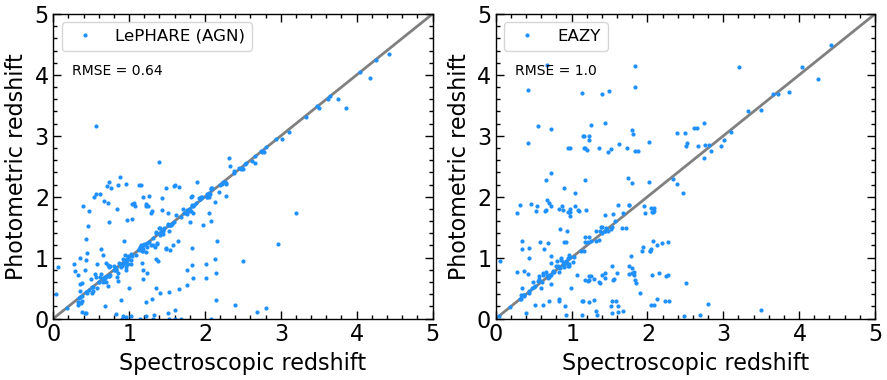

In [74]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

data_agn = ascii.read('hsc_agn.txt')
data_agn_updated = ascii.read('hsc_agn_updated.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')

z_updated = data_agn_updated['z'][idx_agn2COSMOS20]
mask_spec_updated = data_agn_updated['r_z'][idx_agn2COSMOS20] < 2

z_hsc = data_agn['z'][idx_agn2COSMOS20]

z_ez = data_cosmos2020['ez_z_phot'][idx_COSMOS20]
z_agn = data_cosmos2020['lp_zq'][idx_COSMOS20]
mask_spec = data_agn['r_z'][idx_agn2COSMOS20] < 2


fig, axs = plt.subplots(1,2, figsize=(9, 4))

axs[0].errorbar(z_updated[mask_spec_updated], z_agn[mask_spec_updated], color='dodgerblue',
            marker='.', ms=4, linestyle='none', label='LePHARE (AGN)')

axs[0].text(0.25, 4, f'RMSE = {np.round(rmse(z_updated[mask_spec_updated], z_agn[mask_spec_updated]), 2)}')

axs[0].set_xlabel('Spectroscopic redshift')
axs[0].set_ylabel('Photometric redshift')


axs[0].legend(frameon=True, fontsize=12, loc=2)
axs[0].plot([-1, 5], [-1, 5], color='gray', zorder=-1)

axs[0].set_xlim(0, 5)
axs[0].set_ylim(0, 5)

###

axs[1].errorbar(z_updated[mask_spec_updated], z_ez[mask_spec_updated], color='dodgerblue',
            marker='.', ms=4, linestyle='none', label='EAZY')

mask_outlier = z_ez < 5
axs[1].text(0.25, 4, f'RMSE = {np.round(rmse(z_updated[mask_spec_updated & mask_outlier], z_ez[mask_spec_updated & mask_outlier]), 2)}')


axs[1].set_xlabel('Spectroscopic redshift')
axs[1].set_ylabel('Photometric redshift')

axs[1].legend(frameon=True, fontsize=12, loc=2)
axs[1].plot([-1, 5], [-1, 5], color='gray', zorder=-1, label='y=x')

axs[1].set_xlim(0, 5)
axs[1].set_ylim(0, 5)

fig.tight_layout()
fig.savefig('photoz.pdf', dpi=300)

Check if SIMBAD spec-z and Kiruma20 spec-z are consistent

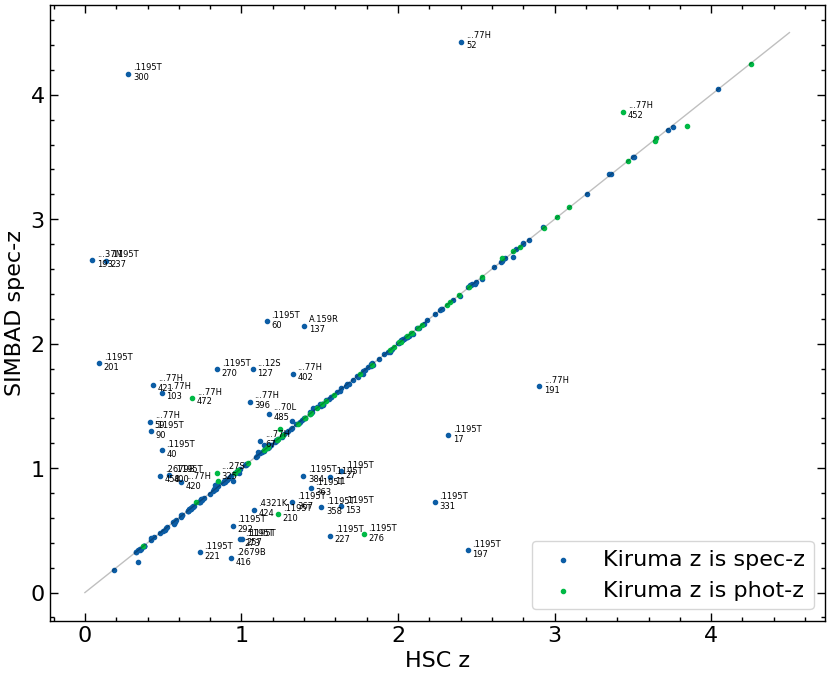

In [19]:
data_agn_compare = table.Table(data=[[0.]*491, ['none']*491, [0.]*491, ['-'*19]*491, [None]*491], 
                               names=['HSC-z', 'r_HSC-z', 'SIMBAD-z', 'bib_SIMBAD-z', 'name'])
for j,i in enumerate(idx_simbad_specz):
    if data_agn['r_z'][i] <= 2:
        data_agn_compare['r_HSC-z'][i] = 'spec'
    else: 
        data_agn_compare['r_HSC-z'][i] = 'phot'
    data_agn_compare['HSC-z'][i] = data_agn['z'][i]
    data_agn_compare['SIMBAD-z'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_compare['bib_SIMBAD-z'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]
    data_agn_compare['name'][i] = result_table[mask_spec_simbad]['MAIN_ID'][j]

plt.figure(figsize=[10, 8])

plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='Kiruma z is spec-z')
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='Kiruma z is phot-z')
# add bibcode to interested dots
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if (np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1) : 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]+0.03), size=6)
        plt.annotate(i+1, (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()
